# 任务 1: PCA 或 Kernel PCA 降维分析 (10 分)

## **实验目标**
使用 **PCA** 或 **Kernel PCA** 对 CIFAR-10 或 MNIST 数据集进行降维，观察前两个主成分特征向量对应的图像表现，将数据嵌入到二维空间（R²），并绘制降维后的数据分布。分析二维特征是否能够完成对输入的分类，并对结果进行评价。

我这里选择的是CIFAR-10，第一件事当然是加载数据集，数据集已经加载过很多次了这里也不详细讲了。

---

In [2]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def load_cifar10_datasets(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_data = []
    train_labels = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']
    
    train_data = np.vstack(train_data).astype(np.float32)
    train_labels = np.array(train_labels)
    
    test_batch = unpickle(os.path.join(data_dir, "test_batch"))
    test_data = test_batch[b'data'].astype(np.float32)
    test_labels = np.array(test_batch[b'labels'])
    
    return (train_data, train_labels), (test_data, test_labels)

train_set, test_set = load_cifar10_datasets('cifar-10-batches-py/')
train_x, train_y = train_set
test_x, test_y = test_set
print(train_x.shape)
print(train_y.shape)

(50000, 3072)
(50000,)





事已至此，现在我们已经获得了两组**Numpy矩阵和向量**，按理来说这里的x样本需要展开的。但是好像展开都不用了


倒是y的形状不太好，稍后需要处理一下

然后是RGB值在某种意义上来说太大了，为了防止对PCA造成影响，需要标准化一下
标准化的代码很简单，按列算均值标准差，然后样本减去均值除以标准差即可

In [3]:
mean = np.mean(train_x, axis=0)
std = np.std(train_x, axis=0)   
train_x_scaled = (train_x - mean) / std
mean = np.mean(test_x, axis=0) 
std = np.std(test_x, axis=0)    
test_x_scaled = (test_x - mean) / std  

观察前两个主成分特征向量对应的图像表现，我可以理解为把前两个特征向量作为图像打印出来吗

我们可以用PCA给他降降维度到100维

然后得到的应该是100个正交的特征向量

在这100个正交的特征向量里，越后面的特征向量越不关键

CIFAR-10 的一张图片展平后是 3072 维，第一主成分向量的长度也是 3072

要观察前两个主成分特征向量对应的图像表现，我们可以把主成分向量 reshape 成图像

根据数学公式可知，这个图像代表着主成分在像素空间的权重分布，每个像素的值表示该像素对这个主成分的贡献大小

所以我们可以先试试，把这个图像打印出来

(3072,)


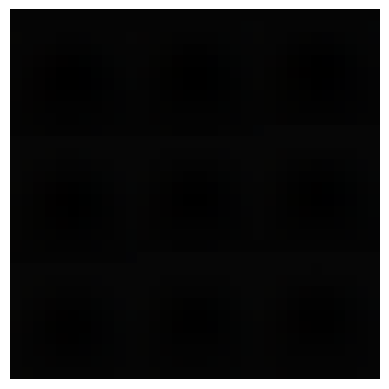

In [3]:
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# 进行PCA变换
train_x_pca = pca.fit_transform(train_x_scaled)
test_x_pca = pca.transform(test_x_scaled)

# 获取PCA计算出的第一个主成分（特征向量）
first_pca_vector = pca.components_[0]

# 打印第一个特征向量的形状，应该是 (3072,)
print(first_pca_vector.shape)

image_shape = (32, 32, 3)
first_pca_image = first_pca_vector.reshape(image_shape)

# 使用matplotlib展示该图像
plt.imshow(first_pca_image)
plt.axis('off')  # 不显示坐标轴
plt.show()



大意了，应该先把这个映射一下到0-255的，不然是全黑的

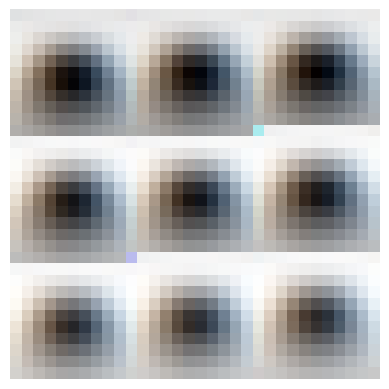

In [4]:
# 将特征向量的值线性映射到 [0, 255] 范围
first_pca_vector_min = np.min(first_pca_vector)
first_pca_vector_max = np.max(first_pca_vector)

# 归一化到 [0, 255] 范围
first_pca_vector_scaled = 255 * (first_pca_vector - first_pca_vector_min) / (first_pca_vector_max - first_pca_vector_min)

image_shape = (32, 32, 3)
first_pca_image = first_pca_vector_scaled.reshape(image_shape)

# 使用matplotlib展示该图像
plt.imshow(first_pca_image.astype(np.uint8))  # 使用 uint8 类型来表示像素值
plt.axis('off')  # 不显示坐标轴
plt.show()

可以看到，中间黑周围是白色的

说明在PCA的变换中，50000张图片里中间的差别要更大，周围的像素差别更小

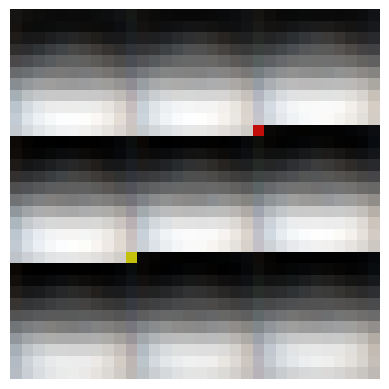

In [5]:
second_pca_vector = pca.components_[1]
# 将特征向量的值线性映射到 [0, 255] 范围
second_pca_vector_min = np.min(second_pca_vector)
second_pca_vector_max = np.max(second_pca_vector)

# 归一化到 [0, 255] 范围
second_pca_vector_scaled = 255 * (second_pca_vector - second_pca_vector_min) / (second_pca_vector_max - second_pca_vector_min)

image_shape = (32, 32, 3)
second_pca_image = second_pca_vector_scaled.reshape(image_shape)

# 使用matplotlib展示该图像
plt.imshow(second_pca_image.astype(np.uint8))  # 使用 uint8 类型来表示像素值
plt.axis('off')  # 不显示坐标轴
plt.show()

这是第二个

不过核方法和PCA又不太一样，KPCA 不存储与原始特征维度对应的特征向量，因为KPCA 并未对原始特征空间操作，而是通过核函数映射到高维空间中

因此不能通过first_pca_vector = pca.components_[0]这种代码来绘图

所以KPCA我们就不绘图了

我们用KPCA把数据压到两维，然后再画图，注意这里画图不可以用渐变色，因为区分不够明显看不出规律

Kernel PCA Shape of Training Data: (1000, 2)
Kernel PCA Shape of Testing Data: (10000, 2)


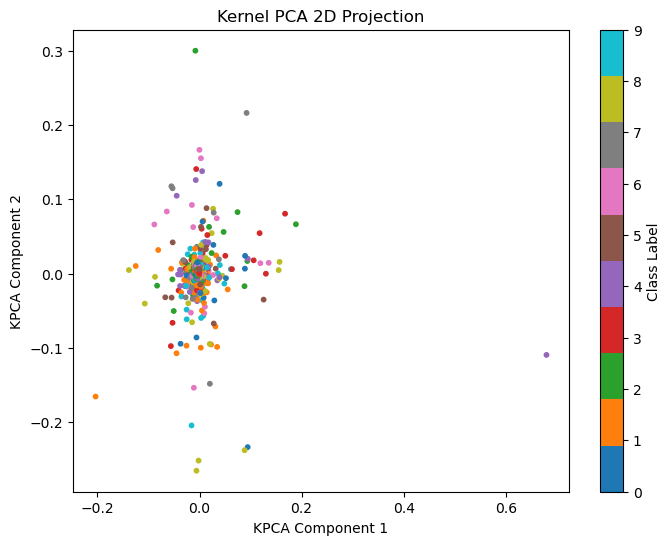

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sample_size = 1000
train_x_sampled = train_x_scaled[:sample_size]
train_y_sampled = train_y[:sample_size]

n_components_kpca = 2  
kpca = KernelPCA(n_components=n_components_kpca, kernel='rbf', gamma=0.1) 
train_x_kpca = kpca.fit_transform(train_x_sampled)
test_x_kpca = kpca.transform(test_x_scaled)

print(f"Kernel PCA Shape of Training Data: {train_x_kpca.shape}")
print(f"Kernel PCA Shape of Testing Data: {test_x_kpca.shape}")

# 使用 tab10 colormap，适合最多 10 个类别
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_x_kpca[:, 0], train_x_kpca[:, 1], 
    c=train_y_sampled, cmap='tab10', s=10  # 使用 tab10 离散调色板
)
plt.xlabel('KPCA Component 1')
plt.ylabel('KPCA Component 2')
plt.title('Kernel PCA 2D Projection')
plt.colorbar(scatter, label='Class Label')
plt.show()

都挤到一坨了啥也看不清，给他在x轴和y轴放大到(-0.01, 0.01)试试

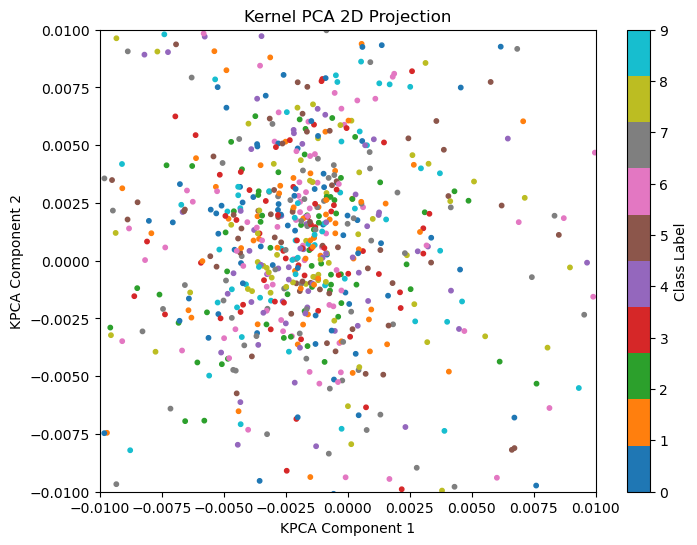

In [11]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_x_kpca[:, 0], train_x_kpca[:, 1], 
    c=train_y_sampled, cmap='tab10', s=10  # 使用 tab10 离散调色板
)
plt.xlabel('KPCA Component 1')
plt.ylabel('KPCA Component 2')
plt.title('Kernel PCA 2D Projection')

# 设置坐标轴范围
plt.xlim(-0.01, 0.01)  # 设置 x 轴范围
plt.ylim(-0.01, 0.01)  # 设置 y 轴范围

plt.colorbar(scatter, label='Class Label')
plt.show()

说实话，我不觉得把3072维下降到两个维度能做出有效的分类器...这实在是看不出有什么明显的规律

PCA Shape of Training Data: (1000, 2)
PCA Shape of Testing Data: (10000, 2)


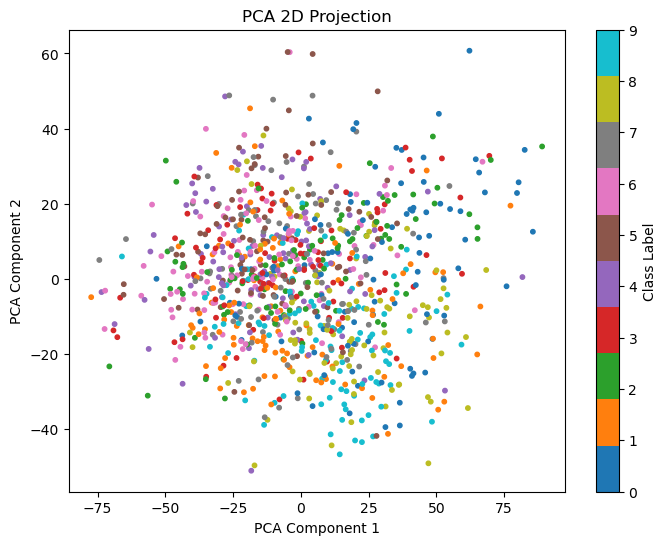

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

sample_size = 1000
train_x_sampled = train_x_scaled[:sample_size]
train_y_sampled = train_y[:sample_size]

n_components_pca = 2  
pca = PCA(n_components=n_components_pca)  # 使用PCA进行降维
train_x_pca = pca.fit_transform(train_x_sampled)
test_x_pca = pca.transform(test_x_scaled)

print(f"PCA Shape of Training Data: {train_x_pca.shape}")
print(f"PCA Shape of Testing Data: {test_x_pca.shape}")

# 使用 tab10 colormap，适合最多 10 个类别
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_x_pca[:, 0], train_x_pca[:, 1], 
    c=train_y_sampled, cmap='tab10', s=10  # 使用 tab10 离散调色板
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA 2D Projection')
plt.colorbar(scatter, label='Class Label')
plt.show()


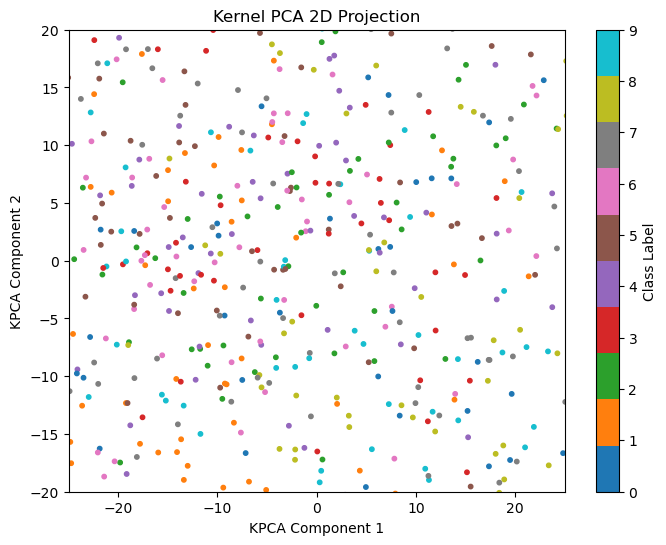

In [5]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    train_x_pca[:, 0], train_x_pca[:, 1], 
    c=train_y_sampled, cmap='tab10', s=10  # 使用 tab10 离散调色板
)
plt.xlabel('KPCA Component 1')
plt.ylabel('KPCA Component 2')
plt.title('Kernel PCA 2D Projection')

# 设置坐标轴范围
plt.xlim(-25, 25)  # 设置 x 轴范围
plt.ylim(-20, 20)  # 设置 y 轴范围

plt.colorbar(scatter, label='Class Label')
plt.show()

看着依旧非常的乱，但是比Kpca好一点点，可以看到，蓝色的点普遍在右边，青色的点普遍在右下角

但是其他的类好像没有这么明显的特征

画一下每个特征值解释的变异比例看看

PCA Shape of Training Data: (1000, 30)
PCA Shape of Testing Data: (10000, 30)
Explained Variance Ratio per Component:
[0.26663116 0.11031169 0.07028709 0.03993369 0.03578131 0.02874593
 0.02816365 0.02448197 0.0206001  0.01459655 0.01364571 0.01178801
 0.01080348 0.01010956 0.00989968 0.00896088 0.00860077 0.00798083
 0.00737613 0.00677147 0.00662259 0.00572377 0.00560992 0.00550854
 0.00528935 0.00514973 0.00502973 0.00482079 0.00474481 0.00433346]


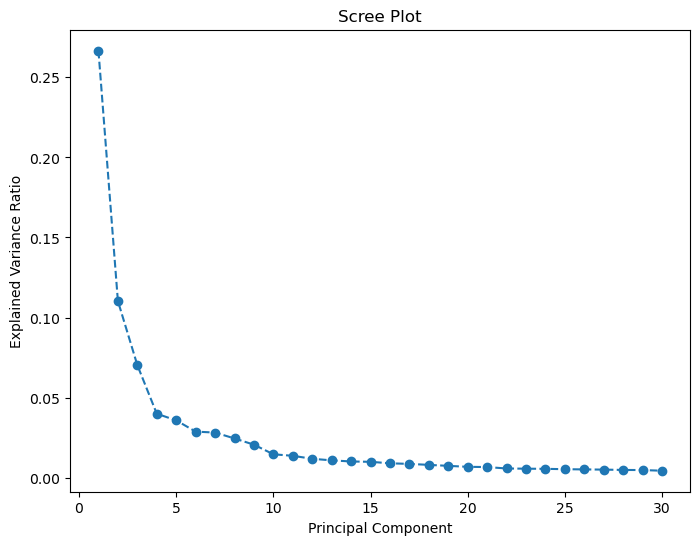

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

n_components_pca = 30  
pca = PCA(n_components=n_components_pca)  # 使用PCA进行降维
train_x_pca = pca.fit_transform(train_x_sampled)
test_x_pca = pca.transform(test_x_scaled)

print(f"PCA Shape of Training Data: {train_x_pca.shape}")
print(f"PCA Shape of Testing Data: {test_x_pca.shape}")

# 输出每个主成分的特征值（方差）和方差比例
print("Explained Variance Ratio per Component:")
print(pca.explained_variance_ratio_)

# 绘制碎石图（Scree Plot）
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components_pca + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

sample_size = 1000
train_x_sampled = train_x_scaled[:sample_size]
train_y_sampled = train_y[:sample_size]

n_components_pca = 2  
pca = PCA(n_components=n_components_pca)  # 使用PCA进行降维
train_x_pca = pca.fit_transform(train_x_sampled)
test_x_pca = pca.transform(test_x_scaled)

# 使用SVM进行分类
svm_classifier = SVC(kernel='linear')  # 使用线性核的SVM
svm_classifier.fit(train_x_pca, train_y_sampled)  # 在降维后的训练数据上训练

# 在降维后的测试数据上进行预测
test_y_pred = svm_classifier.predict(test_x_pca)

# 计算准确率
accuracy = accuracy_score(test_y, test_y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.2043


emmm，不是0.1就好，说明PCA是有一定成效的